In [1]:
import pandas as pd

train = pd.read_csv('/kaggle/input/playground-series-s5e1/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e1/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s5e1/sample_submission.csv')

In [2]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [3]:
train_df_encoded = pd.get_dummies(train, columns=['country', 'store', 'product'])
test_df_encoded = pd.get_dummies(test, columns=['country', 'store', 'product'])

# Align columns of test_df_encoded with train_df_encoded to ensure consistency
test_df_encoded = test_df_encoded.reindex(columns=train_df_encoded.columns, fill_value=0)

In [4]:
X_train = train_df_encoded.drop(columns=['num_sold'])
y_train = train_df_encoded['num_sold']
X_test = test_df_encoded.drop(columns=['num_sold'])

In [5]:
X_train = X_train.drop(columns=['date'])
X_test = X_test.drop(columns=['date'])

In [6]:
%%time

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import numpy as np

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Initialize the model
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

mape_scores = []

for train_index, val_index in kf.split(X_train):
    # Split the data into training and validation sets
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Scale the features
    X_train_fold_scaled = scaler.fit_transform(X_train_fold)
    X_val_fold_scaled = scaler.transform(X_val_fold)

    # Train the model
    model.fit(X_train_fold_scaled, y_train_fold)

    # Make predictions on the validation set
    y_val_pred = model.predict(X_val_fold_scaled)

    # Evaluate MAPE
    mape = mean_absolute_percentage_error(y_val_fold, y_val_pred)
    mape_scores.append(mape)

# Calculate the average MAPE
average_mape = np.mean(mape_scores)
average_mape

CPU times: user 15.3 s, sys: 314 ms, total: 15.6 s
Wall time: 5.06 s


4403381770264817.0

In [7]:
import joblib
joblib.dump(model, 'stiker_sales_model.pkl')

['stiker_sales_model.pkl']

In [8]:
# Scale the test features using the same scaler
X_test_scaled = scaler.transform(X_test)

In [9]:
# Predict on the test set
y_test_pred = model.predict(X_test_scaled)
y_test_pred

array([  13.920365,  758.78186 ,  586.3147  , ..., 1886.7777  ,
       1077.2834  , 1234.8085  ], dtype=float32)

In [10]:
submission = sample_submission.copy()

In [11]:
submission['num_sold'] = y_test_pred

In [12]:
submission.head()

,id,num_sold
0,230130,13.920365
1,230131,758.781860
2,230132,586.314697
3,230133,341.057220
4,230134,402.154144


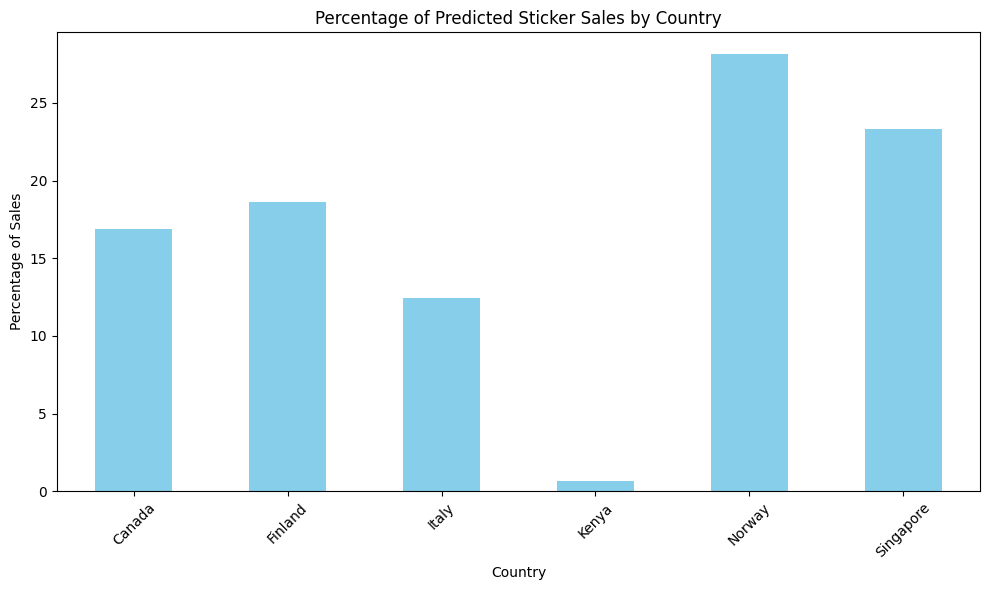

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Add predictions to the test dataframe
test['predicted_num_sold'] = y_test_pred

# Filter for sticker sales (store-related columns)
sticker_sales = test[(test['store'] == 'Discount Stickers') | 
                        (test['store'] == 'Premium Sticker Mart') | 
                        (test['store'] == 'Stickers for Less')]

# Group by country and calculate total predicted sales
country_sales = sticker_sales.groupby('country')['predicted_num_sold'].sum()

# Calculate percentage of sales per country
country_sales_percentage = (country_sales / country_sales.sum()) * 100

# Visualize the percentage sales
country_sales_percentage.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Percentage of Predicted Sticker Sales by Country')
plt.ylabel('Percentage of Sales')
plt.xlabel('Country')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Finland & Singapore are the most sticker sales by country

In [16]:
# Save DataFrame to a CSV file
output_csv_path = 'submission.csv'
submission.to_csv(output_csv_path, index=False)